#### Import modules

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [82]:
# img_path = 'images/baymax.png'
# img_path = 'images/baymax2.png'
# img_path = 'images/baymax3.jpeg'
# img_path = 'images/melody.jpg'
# img_path = 'images/white.png'
# img_path = 'images/baymaxAndHiro.jpg'
img_path = 'images/baymax4.jpg'
# img_path = 'images/baymax5.png'

In [83]:
def crop_img_square(img):
    height, width = img.shape[:2]
    crop = abs(height - width) // 2
    if height > width:
        return img[crop:height-crop,:,:]
    else:
        return img[:,crop:width-crop,:]

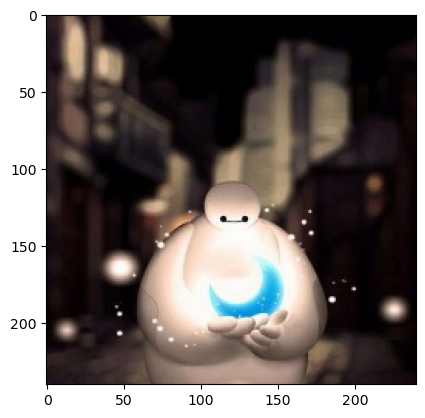

In [84]:
width, height = 240, 240
img = cv2.imread(img_path)

if '.jpg' in img_path or '.png' in img_path:
    img = img[..., ::-1]

img = crop_img_square(img)
img = cv2.resize(img, (height, width))
plt.imshow(img)

In [85]:
def rgb_to_rgb565(rgb_img):
    """
    Convert RGB image (height, width, 3)[uint8] into RGB565 (height, width)[uint16]
    """
    h, w, _ = rgb_img.shape
    rgb565 = np.zeros((h, w), dtype=np.uint16)
    
    for y in range(h):
        for x in range(w):
            r, g, b = rgb_img[y, x]
            new_r = (r >> 3) & 0x1F
            new_g = (g >> 2) & 0x3F
            new_b = (b >> 3) & 0x1F

            color = (new_r << 11) | ((new_g) << 5) | new_b
            rgb565[y, x] = color
    return rgb565

def img_to_bytes(img):
    """
    Convert RGB image into RGB565 bytes
    """
    rgb565_img = rgb_to_rgb565(img)
    img_bytes = rgb565_img.flatten().tobytes()
    return img_bytes

def img_to_bytes_with_pos(img):
    """
    Convert RGB image into RGB565 bytes with (x, y) before its color bytes
         (x, y)  color
         vv vv    vv
    e.g. 00 0f ff f0
               ^^
              color
    """
    rgb565_img = rgb_to_rgb565(img)
    h, w = rgb565_img.shape
    
    flattened_img = rgb565_img.flatten()
    img_with_pos = np.zeros(flattened_img.size * 2, dtype=np.uint16)
    
    x, y = 0, 0
    for i in range(flattened_img.size):
        pos = (y & 0xFF) | (x << 8)
        img_with_pos[2 * i] = pos
        img_with_pos[2 * i + 1] = flattened_img[i]
        
        # Update (x, y)
#         print(f'({x}, {y})')
        x += 1
        if x >= w:
            y += 1
            x = 0
        if y >= h:
            x, y = 0, 0
#             return img_with_pos.tobytes()
            return img_with_pos.tobytes()
    
    return img_with_pos.tobytes()

In [86]:
import paho.mqtt.client as mqtt

In [87]:
mqtt_broker = '192.168.1.101'
mqtt_username = 'testUser'
mqtt_password = 'Abc_072179'
topic = 'test/esp32'

In [88]:
# img_bytes = img_to_bytes(img)

# flattened_img = img_to_bytes_with_pos(img)

# pos_img = img_to_bytes_with_pos(img)
# print(img.size)
# print(pos_img)
img_bytes = img_to_bytes_with_pos(img)
# for i in img_bytes:
#     print(i)

In [89]:
# Define callbacks
def on_connect(client, userdata, flags, rc):
    print('Connected with result code: ' + str(rc))

def on_publish(client, userdata, mid):
#     print('Message published')
    pass

publisher = mqtt.Client()
publisher.username_pw_set(mqtt_username, mqtt_password)

publisher.on_connect = on_connect
publisher.on_publish = on_publish

publisher.connect(mqtt_broker, 1883)
publisher.loop_start()
publisher.loop_stop()

Connected with result code: 0


In [90]:
chunk_size = 128
count = 0;
for i in range(0, len(img_bytes), chunk_size):
    data_chunk = img_bytes[i:i+chunk_size]
    count += len(img_bytes[i:i+chunk_size])
    publisher.publish(topic, data_chunk, qos=2)
    publisher.loop_start()
    publisher.loop_stop()
print('Done')

Done


## Define a class for MQTT publisher client

In [75]:
class ImageSender:
    # Define config data
    BROKER = '192.168.1.101'
    PORT = 1883
    USERNAME = 'testUser'
    PASSWORD = 'Abc_072179'
    TOPIC = 'test/esp32'
    
    MAX_CHUNK_SIZE = 128
    
    SIZE = (240, 240)
    
    def __init__(self):
        self.publisher = mqtt.Client(client_id='image-displayer')
        self.publisher.username_pw_set(self.USERNAME, self.PASSWORD)
        self.publisher.on_connect = self._on_connect
        self.publisher.on_publish = self._on_publish
        
        self.publisher.connect(self.BROKER, self.PORT)
        self.publisher.loop_start()
        self.publisher.loop_stop()
    
    def _on_connect(self, client, userdata, flags, rc):
        # connect callback for mqtt client
        print('Connected with result code ' + str(rc))
    
    def _on_publish(self, client, userdata, mid):
        # publish callback for mqtt client
        print('Message published')
    
    def _send_data(self, data):
        """
        Send a data to target
        """
        self.publisher.publish(self.TOPIC, data, qos=2)
        self.publisher.loop_start()
        self.publisher.loop_stop()
    
    def crop_img(self, img):
        """
        Crop the image into a square
        """
        height, width = img.shape[:2]
        crop = abs(height - width) // 2
        if height > width:
            return img[crop:height-crop,0:,0:]
        else:
            return img[0:crop:width-crop,0:]
    
    def rgb_to_rgb565(self, rgb_img):
        """
        Convert RGB image (height, width, 3)[uint8] into RGB565 (height, width)[uint16]
        """
        h, w, _ = rgb_img.shape
        rgb565 = np.zeros((h, w), dtype=np.uint16)

        for y in range(h):
            for x in range(w):
                r, g, b = rgb_img[y, x]
                new_r = (r >> 3) & 0x1F
                new_g = (g >> 2) & 0x3F
                new_b = (b >> 3) & 0x1F

                color = (new_r << 11) | ((new_g) << 5) | new_b
                rgb565[y, x] = color
        return rgb565
    
    def img_to_bytes(self, img):
        """
        Convert RGB image into RGB565 bytes with (x, y) before its color bytes
        """
        cropped_img = self.crop_img(img)
        resized_img = cv2.resize(cropped_img, self.SIZE)
#         rgb565_img = self.rgb_to_rgb565(resized_img)
        h, w = rgb565_img.shape

        flattened_img = rgb565_img.flatten()
        img_with_pos = np.zeros(flattened_img.size * 2, dtype=np.uint16)

        x, y = 0, 0
        for i in range(flattened_img.size):
            pos = (y & 0xFF) | (x << 8)
            img_with_pos[2 * i] = pos
            img_with_pos[2 * i + 1] = flattened_img[i]

            # Update (x, y)
    #         print(f'({x}, {y})')
            x += 1
            if x >= w:
                y += 1
                x = 0
            if y >= h:
                x, y = 0, 0
                return img_with_pos.tobytes()

        return img_with_pos.tobytes()
        
    def send_bytes(self, data, chunk_size):
        for i in range(0, len(data), chunk_size):
            self._send_data(data[i:i+chunk_size])
        print('Done')
    
    def send_img(self, img):
        """
        Send an image to target
        """
        img_bytes = img_to_bytes(img)
        self.send_bytes(img_bytes, self.MAX_CHUNK_SIZE)

In [81]:
img_path = 'images/baymax4.jpg'
img = cv2.imread(img_path)

57600


In [77]:
sender = ImageSender()
a = sender.img_to_bytes(img)

Connected with result code 0


In [79]:
len(a)

230400

## Play animation

In [ ]:
def send_img(img):
    # Set up mqtt connection to get ready to send data
    
    # Pre-process the image into 240x240 image
    
    # Convert image into bytes and target readable form
    
    # Send the image data through mqtt client with level 2 qos
    pass

In [ ]:
def play_animation(imgs):
    # Set up the first pixel
    first_pixel = imgs[0]
    
    